# **Introduction**

## Causal Effects Of Gender On Smoking Behavior

**Group Members**
1. Sonali Singh (sks9370)
2. Mohammad Zahid (mz3327)


Find our dataset [here](https://www.kaggle.com/datasets/utkarshx27/smoking-dataset-from-uk/data).

This study investigates the causal effects of *gender on smoking behavior*, while accounting for *marital status as a potential confounding variable*. Our analysis is underpinned by a DAG that models the relationships between our primary outcome, smoking behavior (S), and the key variables of gender (G), marital status (M), and age (A). The DAG illustrates the hypothesized pathways through which gender may directly influence smoking and how this effect could be modified by marital status and age. Employing Bayesian statistical methods, we aim to quantify the direct and total causal effects of gender on smoking, providing clearer insights into how these variables interact. The outcomes of this study are expected to refine our understanding of the determinants of smoking and aid in the development of targeted public health strategies.



**G = Gender**

**S = Smoking**

**M = Marital Status**

**A = Age**

![](DAG_proj.png)

In the DAG provided, there are two paths from G to S: G -> M -> S and G -> M <- A -> S. In the second path M is a collider so conditioning on M here would open the second path and create an association between G and A. Therefor there is no need to stratify by A in our model to estimate the total causal influence of G on S.

# Importing Libraries

In [ ]:
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.special import expit as logistic

import pymc as pm

from matplotlib import pyplot as plt
import pandas as pd

import arviz as az

sns.set_context("talk")
plt.style.use('dark_background')

from scipy.special import expit as logistic
np.random.seed(5)



%matplotlib inline

%config Inline.figure_format = 'retina'
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

# Exploratory Data Analysis (EDA)

In [ ]:
df = pd.read_csv("smoking.csv", header=0)
df = df[['gender', 'smoke', 'marital_status']]
df.head()

,gender,smoke,marital_status
0,Male,No,Divorced
1,Female,Yes,Single
2,Male,No,Married
3,Female,No,Married
4,Female,No,Married


### Number of people who smoke

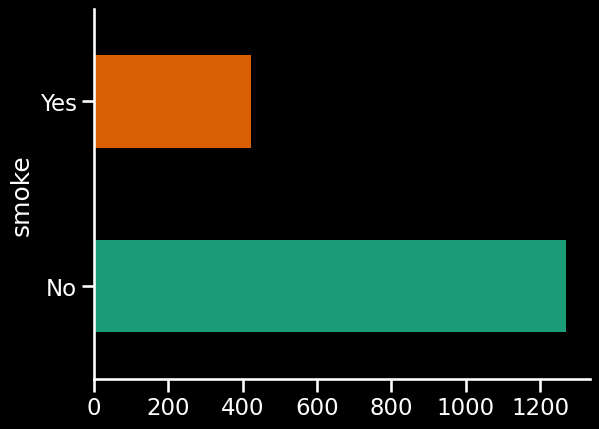

In [ ]:
df.groupby('smoke').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Number of males and females

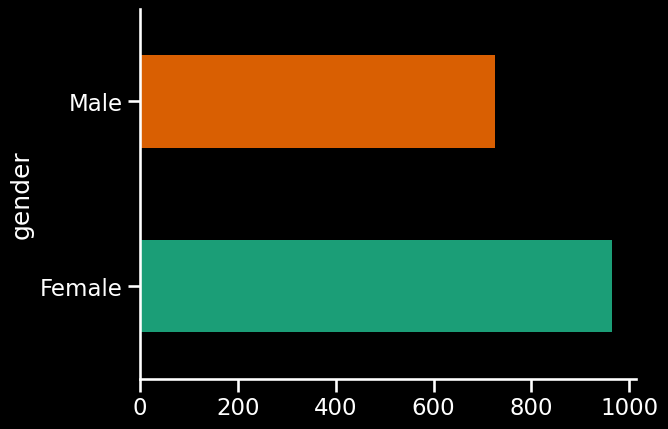

In [ ]:
df.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Number of people who are Single, Married, Divorced, Widowed

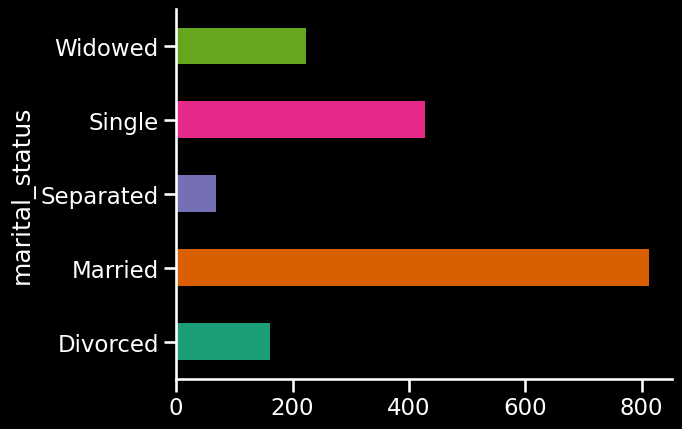

In [ ]:
df.groupby('marital_status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Number of Males and Females who smoke and don't smoke

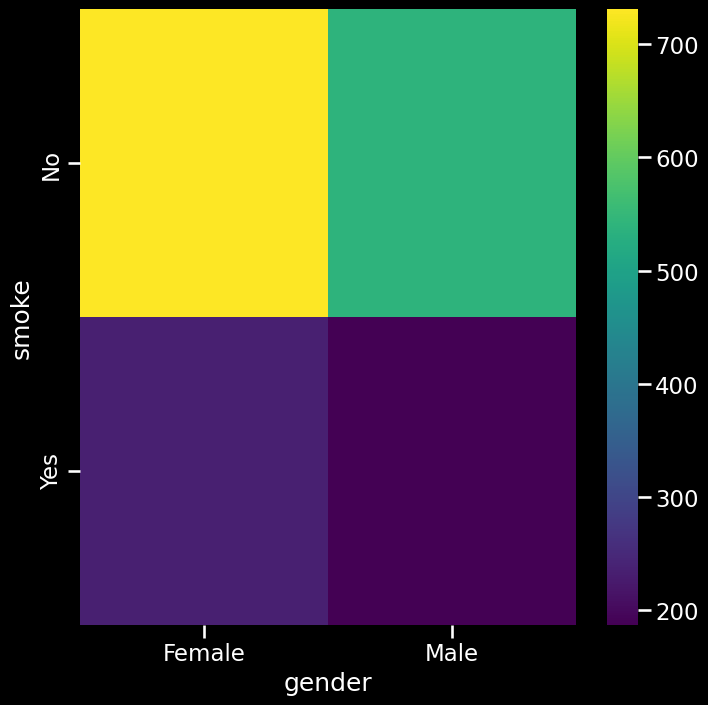

In [ ]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['smoke'].value_counts()
    for x_label, grp in df.groupby('gender')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('gender')
_ = plt.ylabel('smoke')

### Martial Status of Smokers and Non-**smokers**

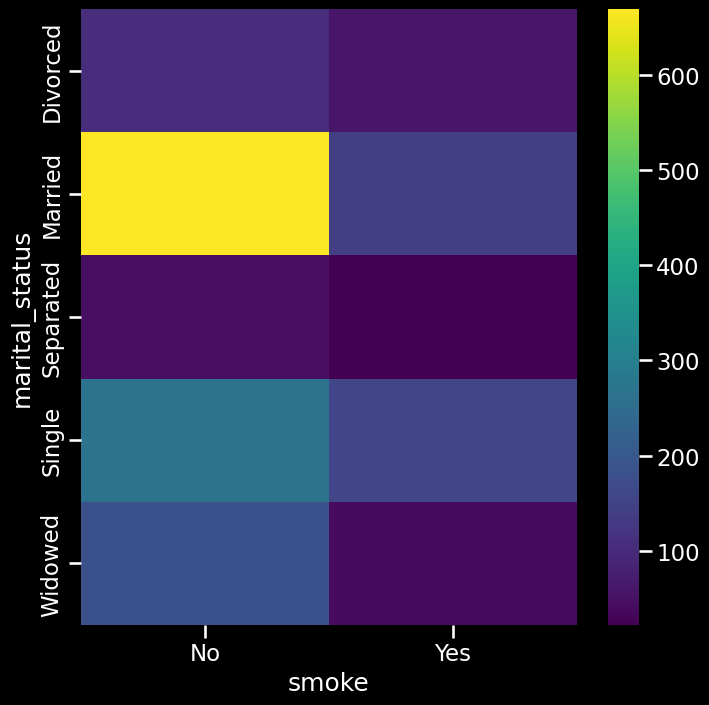

In [ ]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['marital_status'].value_counts()
    for x_label, grp in df.groupby('smoke')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('smoke')
_ = plt.ylabel('marital_status')

## Data Processing

In [ ]:
# Add 'total_count' column
df['total_count'] = 1

# Group by 'marital_status', 'gender', and 'smoke', and calculate counts
grouped = df.groupby(['marital_status', 'gender', 'smoke']).size().unstack('smoke', fill_value=0)

grouped

smoke                   No  Yes
marital_status gender          
Divorced       Female   69   42
               Male     34   16
Married        Female  351   72
               Male    318   71
Separated      Female   32   14
               Male     14    8
Single         Female  141   81
               Male    128   77
Widowed        Female  138   25
               Male     45   15

In [ ]:
result = grouped.reset_index()

result

smoke,marital_status,gender,No,Yes
0,Divorced,Female,69,42
1,Divorced,Male,34,16
2,Married,Female,351,72
3,Married,Male,318,71
4,Separated,Female,32,14
5,Separated,Male,14,8
6,Single,Female,141,81
7,Single,Male,128,77
8,Widowed,Female,138,25
9,Widowed,Male,45,15


In [ ]:
result['total_smoke'] = result['Yes']
result['total_count'] = result['Yes'] + result['No']

result

smoke,marital_status,gender,No,Yes,total_smoke,total_count
0,Divorced,Female,69,42,42,111
1,Divorced,Male,34,16,16,50
2,Married,Female,351,72,72,423
3,Married,Male,318,71,71,389
4,Separated,Female,32,14,14,46
5,Separated,Male,14,8,8,22
6,Single,Female,141,81,81,222
7,Single,Male,128,77,77,205
8,Widowed,Female,138,25,25,163
9,Widowed,Male,45,15,15,60


In [ ]:
result['smoking_proportion'] = result['total_smoke'] / (result['total_count'])
result

smoke,marital_status,gender,No,Yes,total_smoke,total_count,smoking_proportion
0,Divorced,Female,69,42,42,111,0.378378
1,Divorced,Male,34,16,16,50,0.320000
2,Married,Female,351,72,72,423,0.170213
3,Married,Male,318,71,71,389,0.182519
4,Separated,Female,32,14,14,46,0.304348
5,Separated,Male,14,8,8,22,0.363636
6,Single,Female,141,81,81,222,0.364865
7,Single,Male,128,77,77,205,0.375610
8,Widowed,Female,138,25,25,163,0.153374
9,Widowed,Male,45,15,15,60,0.250000


# Statistical Modeling

## Model 1 - Normal Distribution

**Bayesian model set up**

* Total Model: four parameters are defined: $α$, $β$, $γ$, and $σ$.
$α$ and $γ$ are modeled as Normal distributions, which suggests that they are continuous and can take on any real-valued number (we know that our data is binary). This is typical for regression coefficients in a linear model.
$β$ is modeled as an Exponential distribution, which is a continuous distribution. $σ$ is modeled as a HalfNormal distribution, i.e. the standard deviation of the observed data.
The outcome variable smoke_obs is modeled as a Normal distribution, with $μ$ as the mean, which is calculated as $𝛂 + β(x)$.

* Direct Model: Similar to the Total Model, including an additional term g, which is multiplied by mu_direct. This term represents an interaction or direct effect, with Marital_status_direct being another predictor.

**Variables**

*   S: Number of smokers
*   N: Total count of individuals.
*   G: Gender, encoded as 0 for female and 1 for male
*   M: Marital status encoded as categorical codes

In [ ]:
S = result.total_smoke
N = result.total_count
G = np.where(result["gender"] == "Female", 0, 1)
M = pd.Categorical(result.marital_status).codes

<ipython-input-29-bd5933bb0a69>:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(trace_total.posterior['beta'].values.flatten(), shade=True, color='red', label='Total Effect')
<ipython-input-29-bd5933bb0a69>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(trace_direct.posterior['beta'].values.flatten(), shade=True, color='blue', label='Direct Effect')


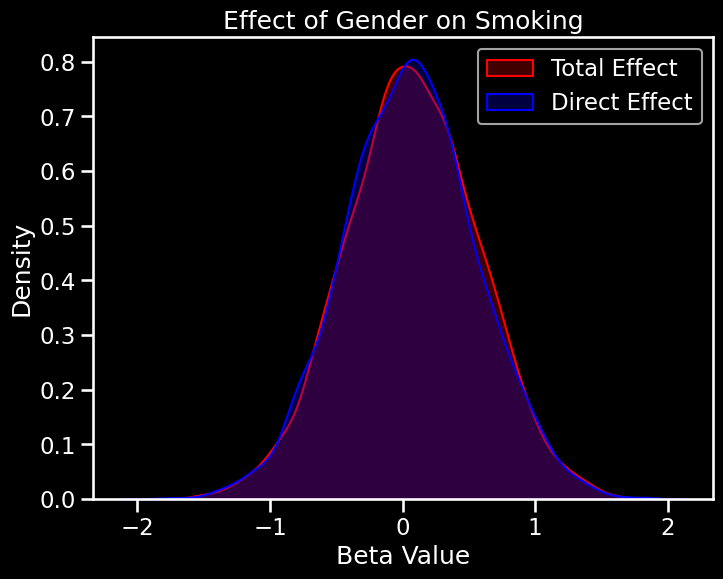

In [ ]:
# Total Model:
with pm.Model() as model_total:
    alpha = pm.Normal('alpha', 0, 0.2)
    beta = pm.Normal('beta', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = alpha + beta * G
    smoke_obs = pm.Normal('smoke_obs', mu, sigma, observed=S)

    trace_total = pm.sample(2000, tune=1000, chains=2)

# Direct Model
with pm.Model() as model_direct:
    alpha = pm.Normal('alpha', 0, 0.2)
    beta = pm.Normal('beta', 0, 0.5)
    gamma = pm.Normal('gamma', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu_direct = alpha + beta * G + gamma * M
    Gender_direct = pm.Normal('Gender_direct', mu_direct, sigma, observed=S)

    trace_direct = pm.sample(2000, tune=1000, chains=2)


# Plotting the combined results
plt.figure(figsize=(8, 6))
sns.kdeplot(trace_total.posterior['beta'].values.flatten(), shade=True, color='red', label='Total Effect')
sns.kdeplot(trace_direct.posterior['beta'].values.flatten(), shade=True, color='blue', label='Direct Effect')
plt.title('Effect of Gender on Smoking')
plt.xlabel('Beta Value')
plt.ylabel('Density')
plt.legend()
plt.show()


**Graph Interpretations**

The KDE plot above visualizes the posterior distribution of the β parameter from both models. The 'Total Effect' (in red) and the 'Direct Effect' (in blue) are overlaid, allowing for visual comparison of their distributions.

**Unsuitability for Binary Outcome**

The main issue indicated by data is that the outcome variable is binary, however the models use a Normal distribution to model smoke_obs. This proves to be problematic because a Normal distribution assumes the outcome is continuous, whereas a binary outcome should be modeled with a distribution that reflects its dichotomous nature, such as a Bernoulli distribution for a single trial or a Binomial distribution for multiple trials.

The use of Normal distributions for smoke_obs in both the "Total" and "Direct" models implies that the models are set up for continuous outcomes. As a result, these models would not appropriately capture the behavior of a binary outcome variable, leading to incorrect inference about the effects of the predictors on the outcome. This is because the model would predict values outside of the 0 and 1 range, which does not make sense for a binary outcome, and it would not account for the fixed variance structure of a binary outcome.

Through this model exploration we decided to use a Logistic Regression model (Binomial distribution) to help answer our initial question.

## Model 2 - Logistic Regression

### Prior Predictive Simulation
#### $$ logit(p_i) = \alpha + \beta(x_i) $$

#### $$ \alpha ∼ Normal(0, 10) $$

#### $$ \beta ∼ Normal(0,10) $$

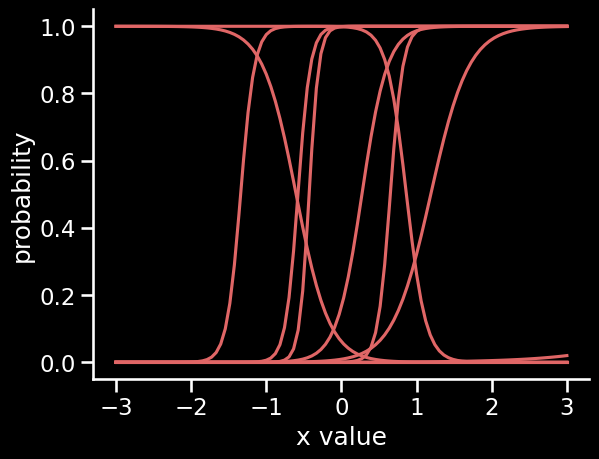

In [ ]:
# Prior Predictive Simulation

alpha = stats.norm.rvs(0,10, size=int(1e4))
beta = stats.norm.rvs(0,10, size=int(1e4))

xseq = np.linspace(-3, 3, num=100)

p = np.empty((len(alpha), len(xseq)))

for i in range(len(alpha)):
    p[i] = logistic(alpha[i] + beta[i] * xseq)

for i in range(10):
    _ = plt.plot(xseq, p[i], color="#e06666")

plt.xlabel("x value")
plt.ylabel("probability")
sns.despine();

### Estimand: Total effect of G

#### $$ S_i ∼ Binomial(N_i, p_i) $$

#### $$ logit(p_i) = \alpha_{[G_i ,M_i]} $$

**Model Description**

Variables:
*   S: Number of smokers
*   N: Total count of individuals.
*   G: Gender, encoded as 0 for female and 1 for male
*   M: Marital status encoded as categorical codes

Model:

*   alpha: A normal distribution is used to create priors for the model's intercepts
*   p: The probability of smoking, computed using the logistic function on alpha
*   mod_S: The observed variable, modeled as a binomial distribution with the probability p

Sampling:

*   idata_G: The sampled posterior distribution after running the model.

In [ ]:
with pm.Model() as m_G:
    alpha = pm.Normal("alpha", 0, 1, shape=2)
    p = pm.Deterministic("p", pm.math.invlogit(alpha[G]))
    mod_S = pm.Binomial("S", N, p, observed=S)

    idata_G = pm.sample()

In [ ]:
az.summary(idata_G, var_names="~p", kind="all")

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-1.133,0.072,-1.242,-1.012,0.002,0.001,1884.0,1460.0,1.0
alpha[1],-1.051,0.083,-1.188,-0.918,0.002,0.001,2045.0,1392.0,1.0


<ipython-input-18-31553f4cde67>:1: FutureWarning: extract_dataset has been deprecated, please use extract
  post1 = az.extract_dataset(idata_G) #extract all posterior samples


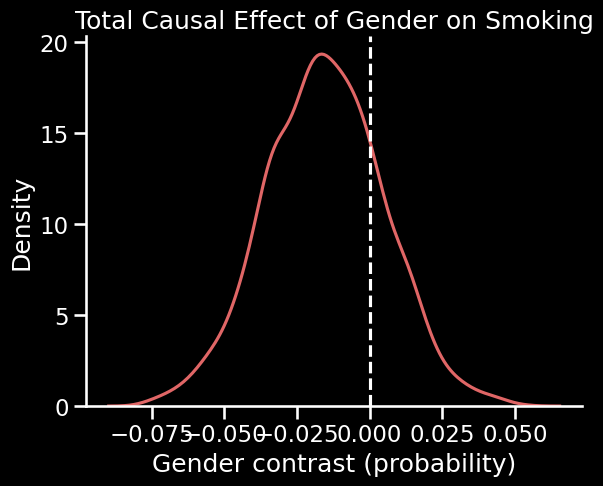

In [ ]:
post1 = az.extract_dataset(idata_G) #extract all posterior samples
probA_Female = logistic(post1.alpha[0])
probA_Male = logistic(post1.alpha[1])
diff_prob = probA_Female - probA_Male

sns.kdeplot(diff_prob, color="#e06666")
plt.xlabel("Gender contrast (probability)")
plt.axvline(0, linestyle="--")
plt.title("Total Causal Effect of Gender on Smoking")
sns.despine();

**Gender Contrast Interpretation**

The Gender Contrast Graph above displays the distribution of the gender contrast, which is a measure of the effect of Gender on Smoking. The x-axis represents the gender contrast, with values to the left of the vertical dashed line (X < 0) corresponding to females, $α[0]$, and values to the right (X > 0) corresponding to males, $α[1]$.

When we examine the graph, we observe that it is centered around a mean value that is slightly to the left of the vertical dashed line. This indicates that, on average, females have a slightly lower probability of Smoking compared to males.

In terms of interpreting the graph, it's important to note that the gender contrast represents the difference between the probabilities of smoking for females and males. A negative gender contrast implies that females have a lower probability of smoking, while a positive gender contrast would suggest the opposite.

To clarify further, consider an example: If we have a gender contrast of -0.03, it means that the probability of females smoking is about 3% lower than that of males.

Therefore, by examining the graph and the mean value of approximately -0.03, we can conclude that, in this dataset and according to this model, males appear to smoke slightly more than females.

**The negative mean value suggests that, on average, males have a slightly higher probability of smoking compared to females.**

**Summary Interpretation**

The summary suggests that gender has a measurable effect on smoking habits, where the alpha parameter for males. $α[1]$ is slightly higher than for females, $α[0]$, implying a higher smoking probability for males within the model's context.

## Counterfactual Simulation

**Model Description**

* The model considers the number of smokers (S), total count of individuals (N), gender (G encoded as 0 for female and 1 for male), and marital status (M encoded as categorical codes).
* It uses a normal distribution to create priors for the intercepts of the model (denoted as alpha).
* The probability of smoking (p) is computed using the logistic function on the alpha parameter.
* The observed variable (mod_S) is modeled as a binomial distribution with the probability p.
* Posterior distributions are sampled and stored in idata_G and idata_GM.

**Counterfactual Simulation:**

* The model sets up a counterfactual scenario using MutableData objects for gender and marital status, allowing the simulation of interventions on these variables.
* Two scenarios are simulated: one where all smokers are women and another where all smokers are men. These are sampled from the posterior predictive distribution and stored in cf_S_Female and cf_S_Male.

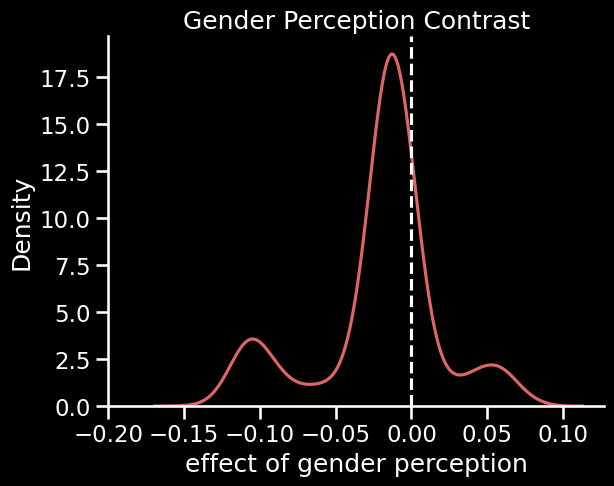

In [ ]:
# model for counterfactual simulation
with pm.Model() as m_GM_cf:
    # pm.Data allow for simulated interventions on variable
    d_G = pm.MutableData("gender", G.astype("int64"))
    d_M = pm.MutableData("marital_status", M.astype("int64"))
    d_N = pm.MutableData("num", N.astype("int64"))

    alpha = pm.Normal("alpha", 0, 1, shape=(2, len(np.unique(M))))
    p = pm.Deterministic("p", pm.math.invlogit(alpha[d_G, d_M]))
    mod_A = pm.Binomial("A", d_N, p, observed=S, shape=d_M.shape[0])

    idata_GM_cf = pm.sample()

# number of people to simulate
total_people = result.total_count.sum()
people_per_marital_status = df.groupby("marital_status")["total_count"].sum()

with m_GM_cf:
    # simulate as if all smokers are women
    pm.set_data(
            {
                "marital_status": np.repeat(range(len(people_per_marital_status)), people_per_marital_status),
                "num": np.repeat(1, total_people),
                "gender": np.repeat(0, total_people)
            }
    )

    cf_S_Female = pm.sample_posterior_predictive(idata_GM_cf)

with m_GM_cf:
    # simulate as if all smokers are men
    pm.set_data(
            {
                "marital_status": np.repeat(range(len(people_per_marital_status)), people_per_marital_status),
                "num": np.repeat(1, total_people),
                "gender": np.repeat(1, total_people)
            }
    )

    cf_S_Male = pm.sample_posterior_predictive(idata_GM_cf)

female_smokers = az.extract(cf_S_Female, group="posterior_predictive")
male_smokers  = az.extract(cf_S_Male, group="posterior_predictive")

# compute smoke rate for each simulation by gender
num_samples = male_smokers.A.values.shape[1]
female_smoke_rate = female_smokers.A.values.sum(1) / num_samples
male_smoke_rate = male_smokers.A.values.sum(1) / num_samples


# plot contrast
sns.kdeplot(female_smoke_rate - male_smoke_rate, color="#e06666")
plt.xlabel("effect of gender perception")
plt.xlim(left=-0.2)
plt.axvline(0, linestyle="--")
plt.title("Gender Perception Contrast")
sns.despine();

### **Insights that can be drawn from the graph**

**Central Tendency:** The peak of the KDE curve is to the left of zero, which suggests that there is a positive average direct effect of being male on the probability of smoking. In other words, males are more likely to smoke than females when marital status is not accounted for.

**Effect Size:** The effect size, indicated by the distance of the peak from zero, seems small but non-negligible. This implies that while gender does have an effect on smoking, it might not be a profoundly large one.

**Potential Subgroups:** The presence of fat tails might hint at the existence of subgroups within the male and female populations that have much stronger or weaker tendencies to smoke. These could be related to unmeasured or unmodeled factors that interact with gender to influence smoking behavior.

In [ ]:
with pm.Model() as m_GM:
    alpha = pm.Normal("alpha", 0, 1, shape=(2, len(np.unique(M))))
    p = pm.Deterministic("p", pm.math.invlogit(alpha[G, M]))
    mod_S = pm.Binomial("S", N, p, observed=S)

    idata_GM = pm.sample()

In [ ]:
az.summary(idata_GM, var_names="~p", kind="all")

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[0, 0]",-0.483,0.190,-0.784,-0.191,0.004,0.003,2471.0,1417.0,1.0
"alpha[0, 1]",-1.562,0.126,-1.757,-1.355,0.002,0.002,2612.0,1568.0,1.0
"alpha[0, 2]",-0.762,0.299,-1.242,-0.286,0.006,0.005,2193.0,1633.0,1.0
"alpha[0, 3]",-0.550,0.134,-0.757,-0.325,0.002,0.002,3005.0,1693.0,1.0
"alpha[0, 4]",-1.647,0.208,-1.940,-1.280,0.004,0.003,2663.0,1500.0,1.0
"alpha[1, 0]",-0.693,0.289,-1.152,-0.224,0.006,0.005,2444.0,1344.0,1.0
"alpha[1, 1]",-1.479,0.129,-1.694,-1.278,0.003,0.002,2645.0,1486.0,1.0
"alpha[1, 2]",-0.503,0.424,-1.147,0.207,0.008,0.008,2616.0,1261.0,1.0
"alpha[1, 3]",-0.499,0.136,-0.722,-0.289,0.003,0.002,2469.0,1759.0,1.0
"alpha[1, 4]",-1.027,0.274,-1.479,-0.614,0.006,0.004,2296.0,1581.0,1.0


In [ ]:
# encoding for legend
marital_status_labels = ["Divorced", "Married", "Separated","Single", "Widowed"]
marital_status_code_dict = {code: label for code, label in zip(sorted(set(M)), marital_status_labels)}
marital_status_code_dict

{0: 'Divorced', 1: 'Married', 2: 'Separated', 3: 'Single', 4: 'Widowed'}

<ipython-input-26-ae613c2bdcaf>:1: FutureWarning: extract_dataset has been deprecated, please use extract
  post2 = az.extract_dataset(idata_GM)


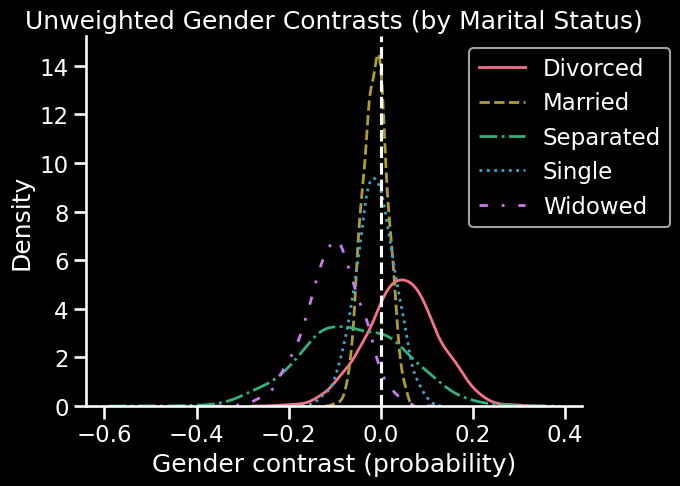

In [ ]:
post2 = az.extract_dataset(idata_GM)
n_marital_status = post2.alpha.shape[1]
n_samples = post2.alpha.shape[2]
probA = logistic(post2.alpha)

palette = sns.color_palette("husl", n_marital_status)

line_styles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5))]

for i in range(n_marital_status):
    proba_G_Female_M = probA[0][i]
    proba_G_Male_M = probA[1][i]
    diff_prob_M = proba_G_Female_M - proba_G_Male_M
    marital_status_label = marital_status_code_dict[i]
    sns.kdeplot(diff_prob_M, color=palette[i], linestyle=line_styles[i], lw=2, label=f'{marital_status_label}')

plt.xlabel("Gender contrast (probability)")
plt.axvline(0, linestyle='--')
plt.legend(bbox_to_anchor=(.75, 1), loc='upper left', ncol=1)
plt.title("Unweighted Gender Contrasts (by Marital Status)")

sns.despine()

plt.show()


**Results**

* **Divorced Females (alpha[0, 0])**: With a mean log-odds of -0.483, the corresponding curve in the graph for "Marital Status 0" peaks near zero or slightly to the right, indicating a **higher** but moderate probability of smoking among divorced females.

* **Divorced Males (alpha[1, 0])**: A mean log-odds of -0.693 for divorced males suggests a lower probability of smoking compared to divorced females. The curve for divorced males would therefore peak further left compared to divorced females, indicating a **lower** probability of smoking.

* **Married Females (alpha[0, 1])**: The mean log-odds of -1.562 is quite negative, indicating a **low** probability of smoking for married females. This is represented by the curve for "Marital Status 1" peaking further to the left on the graph.

* **Married Males (alpha[1, 1])**: The mean log-odds of -1.479, being less negative, suggests a slightly **higher** probability of smoking than married females. The curve for married males would thus peak closer to zero than the curve for married females.

* **Separated Females (alpha[0, 2])**: With a mean log-odds of -0.762, the curve for "Marital Status 2" for females would peak left of zero, indicating a moderate, **lower** but similar probability to males of smoking.

* **Separated Males (alpha[1, 2])**: A mean log-odds of -0.503 indicates a **higher** probability of smoking among separated males than separated females, reflected by the curve peaking closer to zero or slightly to the right.

* **Single Females (alpha[0, 3])**: A mean log-odds of -0.550 suggests a moderate probability of smoking, and the curve for "Marital Status 3" for single females would peak just left **(more male)** of zero.

* **Single Males (alpha[1, 3])**: The mean log-odds of -0.499 for single males is closer to zero, indicating a **higher** probability of smoking.

* **Widowed Females (alpha[0, 4])**: The mean log-odds of -1.647 shows a **low** probability of smoking. The corresponding curve for "Marital Status 4" peaks far left.

* **Widowed Males (alpha[1, 4])**: A mean log-odds of -1.027, being less negative than widowed females, implies a **higher** probability of smoking. The curve for widowed males peaks closer to zero than that for widowed females.

In summary, the graph's curves show the probability differences in smoking by gender within marital statuses. **Males** generally have curves peaking closer to zero or the left, suggesting a **higher** probability of smoking across all marital statuses compared to females. The numerical values from the summary reinforce these observations, with males having less negative mean log-odds values than females in corresponding marital statuses. The spread of the curves indicates the uncertainty around these estimates.


It is especially interesting that while the smallest disparity in smoking habits is observed between single and married individuals, a relatively higher prevalence of smoking is among widowed males. Conversely, the only group where females show a higher smoking rate is among the divorced. This pattern prompts a further investigation to determine if an over-representation of divorced individuals in the dataset might be influencing the results.

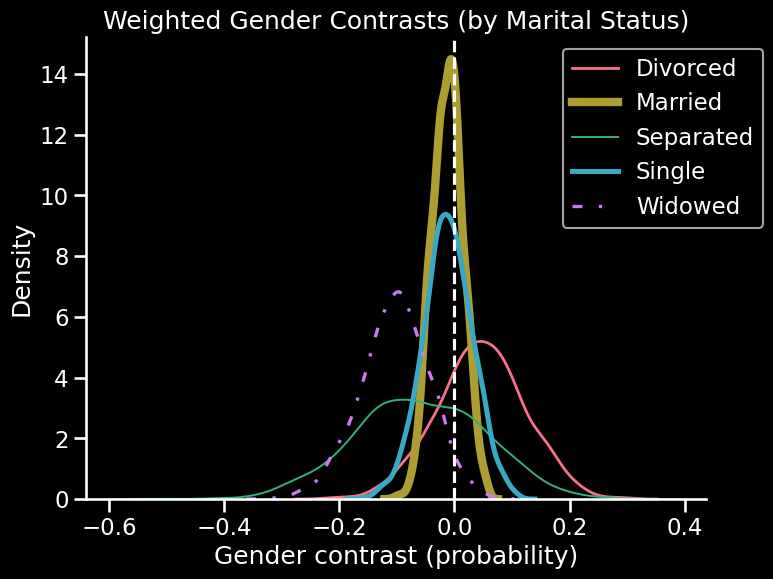

In [ ]:
w = people_per_marital_status / total_people
w = w/max(w)

plt.figure(figsize=(8, 6))

palette = sns.color_palette("husl", n_marital_status)

line_styles = ['-', '-', '-', '-', (0, (3, 5, 1, 5))]

for i in range(n_marital_status):
    # Gender contrasts by department
    probA_Female = probA[0][i]
    probA_Male = probA[1][i]
    diff_prob_M = probA_Female - probA_Male
    marital_status_label = marital_status_code_dict[i]
    sns.kdeplot(diff_prob_M, color=palette[i], linestyle=line_styles[i], lw=1 + 5 * w[i], label=f'{marital_status_label}')

plt.axvline(x=0, linestyle="--")
plt.xlabel("Gender contrast (probability)")
plt.legend(bbox_to_anchor=(0.75, 1), loc='upper left', ncol=1)
plt.title("Weighted Gender Contrasts (by Marital Status)")

sns.despine()

plt.show()

**Upon examining the weighted results, it becomes clear that the direct effect of gender on smoking habits is minimal when factoring in marital status. This is largely due to the dataset predominantly consisting of single or married individuals, among whom the difference in smoking prevalence between men and women is very slight, essentially approaching a zero contrast.Also since the marital statuses that favor either men or women are about the same weight, we know they are not influencing the overall effect of gender on smoking. Its safe to say that while the overall effect of gender on smoking is minimal, men do seem to smoke slightly more. Furthermore, each marital status shows differnt results for the rate of smoking amongst men and women.**